In [1]:
%matplotlib inline
import numpy as np
from spectral_cube import SpectralCube
from astropy import units as u
from matplotlib import pyplot as plt
import warnings 
from astropy.coordinates import SkyCoord
from astroquery.splatalogue import Splatalogue
import aplpy
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.wcs import WCS
from astropy.io import fits
from scipy.signal import find_peaks

warnings.filterwarnings('ignore') # turns of annoying red warning boxes


In [2]:
# for emission across all bands gif
b7 ='/Users/hannahshoemaker/VICO_dust/HH212/HH212data/band7_hannah.fits'
b9 ='/Users/hannahshoemaker/VICO_dust/HH212/HH212data/band9_hannah.fits'
b3 ='/Users/hannahshoemaker/VICO_dust/HH212/HH212data/band3_hannah.fits'
b6 ='/Users/hannahshoemaker/VICO_dust/HH212/HH212data/band6_hannah.fits'

# for emission across all band 7 observations gif

nat2012 = '/Users/hannahshoemaker/VICO_dust/HH212/HH212data/2012cont.fits'
nat2015 = '/Users/hannahshoemaker/VICO_dust/HH212/HH212data/2015.fits'
nat2016x259 = '/Users/hannahshoemaker/VICO_dust/HH212/HH212data/2016_x259.fits'
nat2016x25b = '/Users/hannahshoemaker/VICO_dust/HH212/HH212data/2016_x25b.fits'
nat2017 ='/Users/hannahshoemaker/VICO_dust/HH212/HH212data/2017.fits'

# for emission across all band 7 smooth regrid gif

smooth2012 = '/Users/hannahshoemaker/VICO_dust/HH212/HH212data/2012.smooth.fits'
smooth2015 = '/Users/hannahshoemaker/VICO_dust/HH212/HH212data/2015.smooth.fits'
smooth2016x259 = '/Users/hannahshoemaker/VICO_dust/HH212/HH212data/2016_x259_2.smooth.regrid.fits'
smooth2016x25b =  '/Users/hannahshoemaker/VICO_dust/HH212/HH212data/2016_x25b.regrid.fits'
smooth2017 = '/Users/hannahshoemaker/VICO_dust/HH212/HH212data/2017.smooth.regrid.fits'


In [3]:


def Read_Cube(file_name):
    cube = (SpectralCube.read(file_name))
    cube.spectral_axis
    cube2 = cube.with_spectral_unit(u.km/u.s , velocity_convention = 'radio', rest_value = cube.header['RESTFRQ'] *u.Hz)
    cube2.spectral_axis
    return cube2

def Draw_Box(cube,boxsize):
    boxsize=boxsize
    drawbox_x = [int(cube.shape[2]/2-boxsize),int(cube.shape[2]/2+boxsize)]
    drawbox_y = [int(cube.shape[1]/2-boxsize),int(cube.shape[1]/2+boxsize)]
    cutcube = cube.subcube(xlo = drawbox_x[0],xhi = drawbox_x[1],ylo = drawbox_y[0],yhi = drawbox_y[1])
    return cutcube

        
def RMS(cube):
    b3 = 0.000008576 *u.Jy
    b6 = 0.00002658 *u.Jy
    b7 =0.0000522 *u.Jy
    b9 =0.00266 *u.Jy
    rms2012 = 0.002 *u.Jy
    rms2015 = 0.02662 *u.Jy
    rms2016_x259 = 0.002232 *u.Jy
    rms2016_x25b =0.00367 *u.Jy
    rms2017 = 0.000064 *u.Jy
    rms2012_smooth = 0.00272 *u.Jy
    rms2015_smooth =0.00288 *u.Jy
    rms2016_x259_smooth =0.002044 *u.Jy
    rms2016_x25b_smooth =0.00055 *u.Jy
    rms2017_smooth =0.000436 *u.Jy
        
    casa_rms = b7 #change this depending on which image you are making, I know this is a bad way to do it but I am short on time and this was the easiest solution
        
    return casa_rms

        
def Moment_Maps(cube,cutcube):
    cube.allow_huge_operations=True
    linecube = cube.spectral_slab(-4* u.km / u.s, 14 * u.km / u.s) # defines the "line region" as 0 to 20 km /s
    #moment0 = linecube.moment(order=0) # shows amount of gas at each pixel (column density)
    boxsize=80 
    drawbox_x = [int(cube.shape[2]/2-boxsize),int(cube.shape[2]/2+boxsize)]
    drawbox_y = [int(cube.shape[1]/2-boxsize),int(cube.shape[1]/2+boxsize)]
    cubee = linecube.subcube(xlo = drawbox_x[0],xhi = drawbox_x[1],ylo = drawbox_y[0],yhi = drawbox_y[1],zlo=0,zhi=375)
    moment0 = cubee.moment(order=0)
    red_high = 13.8
    red_low = 11.8
    blue_low = -1
    blue_high = -4
 
    bluecube = cutcube.spectral_slab(blue_low*u.km/u.s, blue_high*u.km/u.s) #define new cube by frequency
    redcube = cutcube.spectral_slab(red_low*u.km/u.s, red_high*u.km/u.s) #define new cube by frequency
    
    bluemom = bluecube.moment(order=0)
    redmom = redcube.moment(order=0)
    
    return moment0,bluemom,redmom
    

def Contours(cube,cutcube,rms,boxsize,figname,additionaltxt):
        fig = aplpy.FITSFigure(cutcube[0,:,:].hdu, dimensions=[0, 1])
        fig.add_beam(major=cube.header['bmaj'],minor=cube.header['bmin'],angle=cube.header['bpa'],fill=True,color='magenta')
        fig.axis_labels.show()
        fig.axis_labels.set_xtext("Right Ascension (ICRS)") 
        fig.axis_labels.set_ytext("Declination (ICRS)") 
        plt.imshow(cutcube[0,:,:].hdu.data, cmap = 'inferno') 
         
        cbar = plt.colorbar(shrink=0.9)
        #cbar.ax.set_ylabel('Moment 0 Map Intensity')

        levs_rms = np.arange(0,1000)*rms.value
        
        print('\u03C3 is', rms.value,'Jy/beam')
    
        fig.show_contour(cutcube[0,:,:].hdu.data,levels = levs_rms[3:4],colors='white',linestyles= 'dashed')
        fig.show_contour(cutcube[0,:,:].hdu.data,levels = levs_rms[5:6], colors='white')
        fig.show_contour(cutcube[0,:,:].hdu.data,levels = levs_rms[10:11], colors='white')
        fig.show_contour(cutcube[0,:,:].hdu.data,levels = levs_rms[20:21], colors='white')
        fig.show_contour(cutcube[0,:,:].hdu.data,levels = levs_rms[50:51], colors='white')
        
        sigma_text = '\u03C3 ='+ str(rms.value) + ' Jy/beam'
        font = {'family': 'veranda','color':  'white','weight': 'bold','size': 16}
        
        if boxsize == 130:
            plt.text(20, 230, sigma_text, fontdict=font)
            plt.text(20,215, additionaltxt,fontdict=font)
        elif boxsize ==50:
            plt.text(10,87, sigma_text, fontdict=font)
            plt.text(10,82, additionaltxt,fontdict=font)
        elif boxsize ==30:
            plt.text(5,53, sigma_text, fontdict=font)
            plt.text(5,50, additionaltxt,fontdict=font)
        elif boxsize ==80:
            plt.text(10,145, sigma_text, fontdict=font)
            plt.text(5,50, additionaltxt,fontdict=font)
        else:
            print("I DO NOT KNOW WHERE TO PUT THE WORDS")
            
     
        fig.savefig(figname+'.png')
        

def Main(file_name,rms,boxsize,figname,additionaltxt):
    cube = Read_Cube(file_name)
    cutcube = Draw_Box(cube,boxsize)
    rms = rms *u.Jy
    Contours(cube,cutcube,rms,boxsize,figname,additionaltxt)


In [4]:
#Main(b7, 0.0000522*u.Jy,130,'b7','ALMA BAND 7')

In [5]:
#Main(b9,0.00266 *u.Jy,50,'b9','ALMA BAND 9')

In [6]:
#Main(b3,0.000008576 *u.Jy,130,'b3','ALMA BAND 3')

In [7]:
#Main(b6,0.00002658 *u.Jy,130,'b6','ALMA BAND 6')

In [8]:
#Main(nat2012,0.004 *u.Jy,30,'nat2012','')

In [9]:
#Main(nat2015,0.0001662 *u.Jy,130,'nat2015','')

In [10]:
#Main(nat2016x259,0.002232 *u.Jy,50,'nat2016x259','')

In [11]:
#Main(nat2016x25b,0.00367 *u.Jy,30,'nat2016x25b','')

In [12]:
#Main(nat2017,0.000064 *u.Jy,80,'nat2017','')

σ is 0.00272 Jy/beam


findfont: Font family ['veranda'] not found. Falling back to DejaVu Sans.


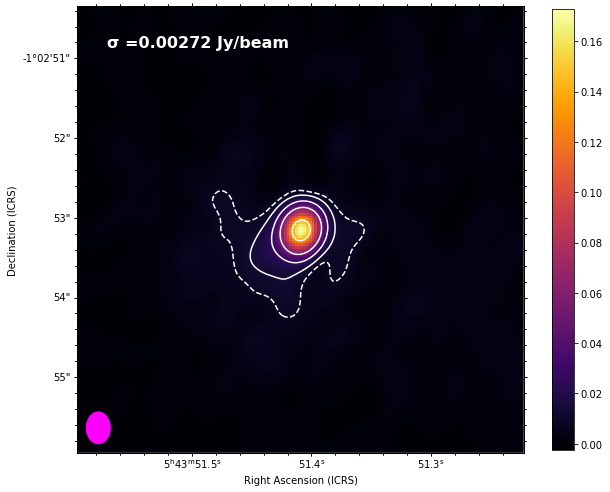

In [13]:
Main(smooth2012,0.00272 *u.Jy,80,'smooth2012','')

σ is 0.00288 Jy/beam


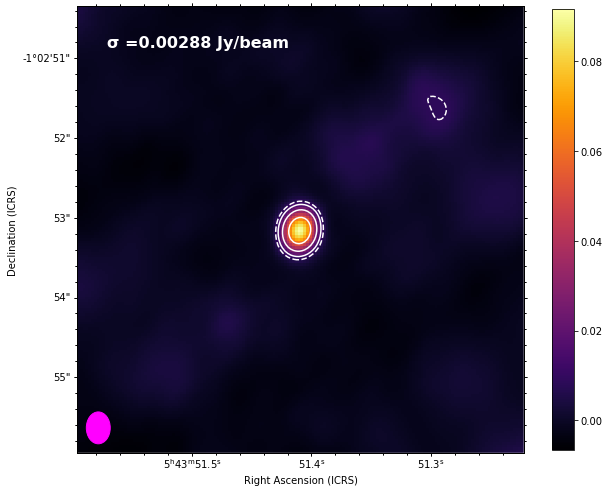

In [14]:
Main(smooth2015,0.00288 *u.Jy,80,'smooth2015','')

σ is 0.0006 Jy/beam


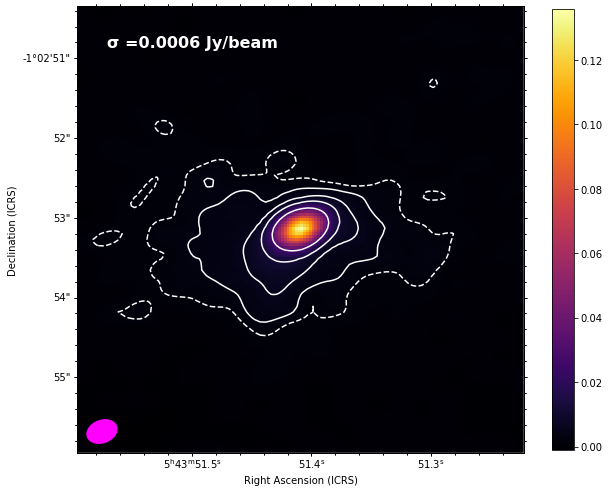

In [19]:
Main(smooth2016x25b,0.0006 *u.Jy,80,'smooth2016x25b','')

σ is 0.000436 Jy/beam


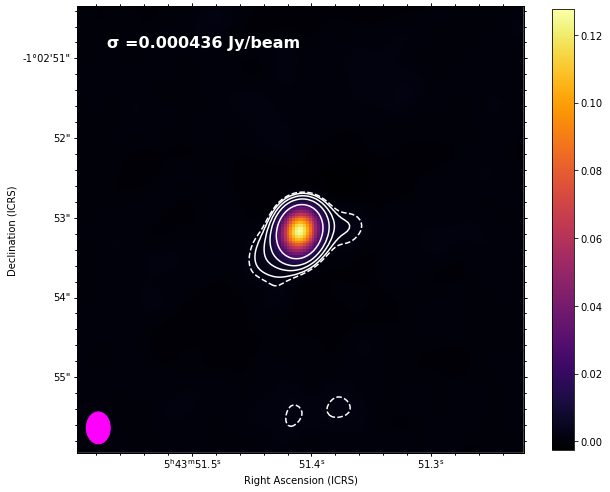

In [17]:
Main(smooth2017,0.000436 *u.Jy,80,'smooth2017','')

σ is 0.002044 Jy/beam


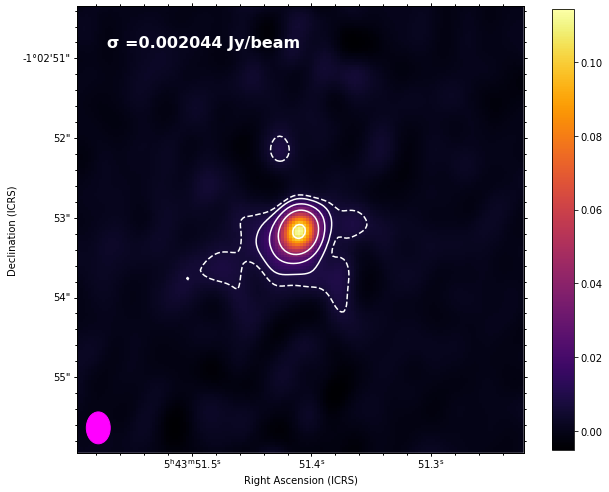

In [24]:
Main(smooth2016x259, 0.002044* u.Jy ,80, 'smooth2016x259', '')
